In [ ]:
#Please execute this cell
import jupman
from pprint import pprint

# Exam -  Wed 10, Feb 2021

**Scientific Programming - Data Science @ University of Trento**

## Download [exercises and solutions](_static/generated/sciprog-ds-2021-02-10-exam.zip)


## Part A - Wikispeedia

[Wikispeedia](https://dlab.epfl.ch/wikispeedia/play/) is a fun game where you are given (or can choose) a source and a target Wikipedia page, and you are asked to reach target page by only clicking links you find along the pages you visit. These click paths provide valuable information regarding human behaviour and the semantic connection between different topics. You will analyze a dataset of such paths.

Data source: https://snap.stanford.edu/data/wikispeedia.html

- Robert West and Jure Leskovec: Human Wayfinding in Information Networks. 21st International World Wide Web Conference (WWW), 2012.
- Robert West, Joelle Pineau, and Doina Precup: Wikispeedia: An Online Game for Inferring Semantic Distances between Concepts. 21st International Joint Conference on Artificial Intelligence (IJCAI), 2009.


Open Jupyter and start editing this notebook `exam-2021-02-10.ipynb`

In [ ]:
import pandas as pd   
import numpy as np    
pd.options.display.max_colwidth = -1
df = pd.read_csv('paths_finished.tsv', encoding='UTF-8', skiprows=16, header=None, sep='\t')

Each row of the dataset [paths_finished.tsv](paths_finished.tsv) is a user _session_, where user navigates from start page to end page. Columns are `hashedIpAddress`, `timestamp`, `durationInSec`, `path` and `rating`.

We define a **session group** as all sessions which have same start page and same end page, for example all these paths start with `Linguistics` and end in `Rome`:

In [ ]:
df[5890:5902]  

In this other session group, all sessions start with `Pikachu` and end with `Sun`:

In [ ]:
df[45121:45138]  

## A1 filter_back

Whenever a user clicks the _Back_ button, she navigates back one page. This fact is tracked in the data by the presence of a `'<'` symbol. Write a function which RETURN a NEW path without pages which were navigated back. 

**NOTE:** **you can have duplicates** even without presence of `<`, because a user might end up to a previous page just by following circular links. Don't misuse search methods, I'm watching you   }:-{

In [ ]:
def filter_back(path):
    
    ret = []    
    
    for page in path:        
        if page == '<':
            if len(ret) > 0:
                ret.pop()            
        else:    
            ret.append(page)    
    return ret
    

assert filter_back([]) == []
assert filter_back(['alfa']) == ['alfa']
assert filter_back(['beta','alfa','charlie']) == ['beta','alfa','charlie']

assert filter_back(['charlie', 'tango','<']) == ['charlie']
inp = ['charlie', 'tango','<']
assert filter_back(inp) == ['charlie']  # new
assert inp == ['charlie', 'tango','<']  
assert filter_back(['alfa', 'beta', 'charlie','<','<','delta']) == ['alfa','delta']
assert filter_back(['alfa', 'beta', 'charlie','delta','eagle','<','<','golf','<','<','hotel']) \
       == ['alfa','beta','hotel']

# circular paths
assert filter_back(['alfa','beta','alfa','alfa','beta']) ==  ['alfa','beta','alfa','alfa','beta']
assert filter_back(['alfa','beta','alfa','<','charlie','charlie','delta','charlie','<','charlie','delta']) \
       == ['alfa','beta','charlie','charlie','delta','charlie','delta']

## A2 load_db

Load the **tab**-separated file [paths_finished.tsv](paths_finished.tsv) with a CSV Reader. The file has some rows to skip and no column names:  parse it and RETURN a list of dictionaries, with `hashedIpAddress`, `timestamp`, `durationInSec`, `path` and `rating` as fields:

- `path`: convert it with `filter_back` function
- `timestamp` and `durationInSec`: convert to integer
- `rating`: convert to integer, if `NULL`, set it to `None`

In [ ]:
import csv

def load_db(filename):
    
   
    
    with open(filename, encoding='utf-8', newline='') as f:        
        my_reader = csv.reader(f, delimiter='\t')                
        
        ret = []                        
        
        for row in my_reader:
            if len(row) < 2:
                continue

            ses = { "hashedIpAddress": row[0],
                    "timestamp" : int(row[1]),
                    "durationInSec" : int(row[2]),
                    "path" : filter_back(row[3].split(';')),
                    "rating": int(row[4]) if row[4] != 'NULL' else None
            }
            
            ret.append(ses)

        print('Parsed', len(ret), 'sessions')
        
        return ret
    
    
sessions_db = load_db('paths_finished.tsv')

sessions_db[:2]

In [ ]:
# TESTING
from pprint import pprint
from expected_db import expected_db
for i in range(0, len(expected_db)):
    if expected_db[i] != sessions_db[i]:
        print('\nERROR at index', i, ':')
        print('  ACTUAL:')
        pprint(sessions_db[i])
        print('  EXPECTED:')
        pprint(expected_db[i])
        break

## A3 calc_stats

Write a function which takes the sessions db and RETURN a NEW dictionary which maps sessions groups expressed as tuples (start, end) to a dictionary of statistics about them

- dictionary key: tuple with start,end page
- `sessions`: the number of sessions in that group
- `avg_len`: the average length (as number of edges) of all paths in the group 
- `pages`: the total number of **DISTINCT** pages found among all sessions in that group
- `freqs`: a dictionary which maps edges found in all sessions of that group to their count
- `max_freq`: the highest count among all freqs

In [ ]:
def calc_stats(sessions):
    
    ret = {}
    
    for session in sessions:
        path = session['path']
        pprint(path)
                                                                            
        t = (path[0], path[-1])
        pprint(t)
        if t in ret:
            ret[t]['avg_len'] += len(path) - 1
            ret[t]['sessions'] += 1
            
            ret[t]['pages_set'].update(path)            
            
        else:    
            ret[t] = { 'avg_len' : len(path) - 1,
                       'sessions' : 1,
                       'pages_set' : set(path),                       
                       'freqs' : {}}
        
        freqs = ret[t]['freqs']
        
        for i in range(1, len(path)):            
            seg = tuple([path[i-1], path[i]])
            if seg in freqs:
                freqs[seg] += 1
            else:
                freqs[seg] = 1
        
    for t in ret:
        ret[t]['avg_len'] = ret[t]['avg_len'] / ret[t]['sessions']
        ret[t]['pages'] = len(ret[t]['pages_set'])        
        freq_vs = ret[t]['freqs'].values()
        ret[t]['max_freq'] = max(freq_vs) if len(freq_vs) > 0 else 0
        del ret[t]['pages_set']
        
    return ret
    
    
stats_db = calc_stats(sessions_db)



In [ ]:
# TESTING
from pprint import pprint
from expected_stats_db import expected_stats_db
for t in expected_stats_db:
    if not t in stats_db:
        print('\nERROR: missing key for session group', t)
        break
    elif expected_stats_db[t] != stats_db[t]:
        print('\nERROR at key for session group', t, ':')
        print('  ACTUAL:')
        pprint(stats_db[t])
        print('  EXPECTED:')
        pprint(expected_stats_db[t])
        break

Output excerpt:

In [ ]:
pprint({ k:stats_db[k] for k in [('Linguistics', 'Rome'), ('Pikachu', 'Sun')]})

## A4 plot_network

Given a sessions group (start_page, target_page), we want to display the pages clicked by users for all its sessions. Since some sessions share edges, we will show their click frequency.

- Set edges attributes `'weight'`, `'label'` as $freq$, `'penwidth'` as $5 \large \frac{freq}{max\_freq}$ and `'color'` as `'#45daed'`
- Only display edges (and pages connected by such edges) for which the click count is _strictly greater_ than the given `threshold` 
- **NOTE:** when applying a threshold, it's fine if some nodes don't appear linked to either source or target

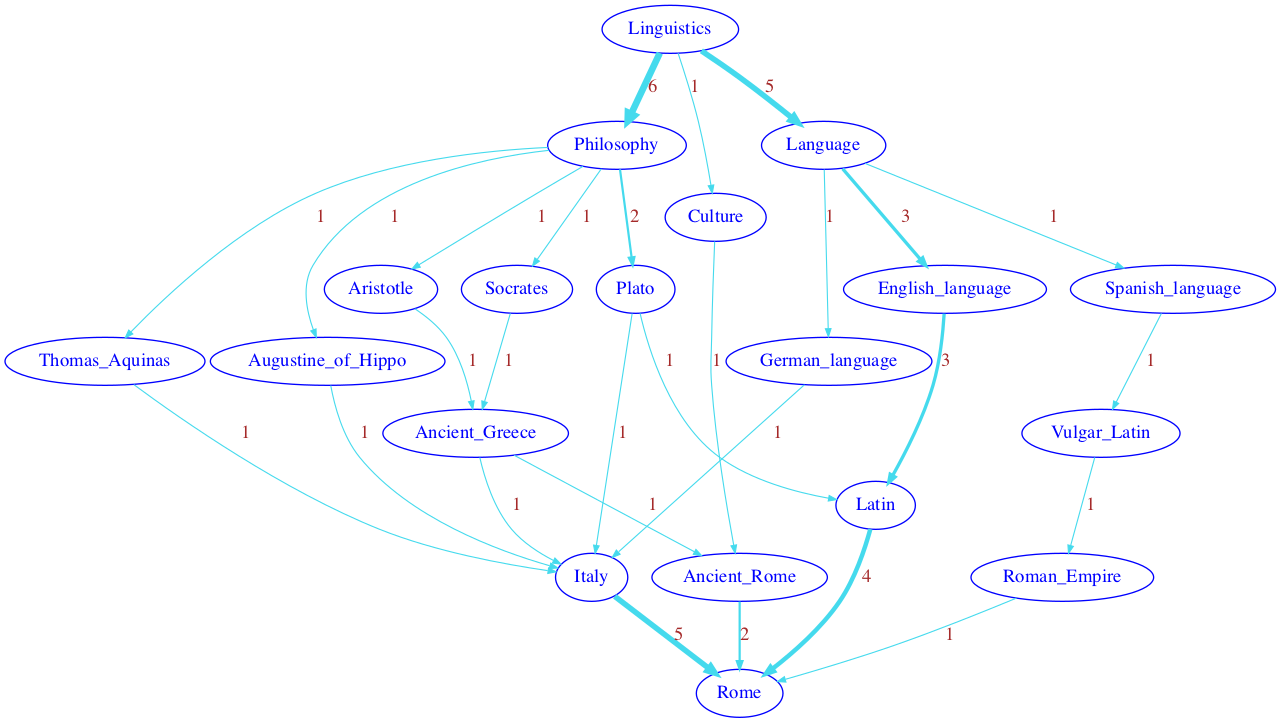

In [14]:
from sciprog import draw_nx
import networkx as nx

def plot_network(stats, source_page, target_page, threshold=0):
    
    
    G = nx.DiGraph()    
                        
    st = stats[(source_page, target_page)]    

    for p1,p2 in st['freqs']:
        
        d = st['freqs'][(p1,p2)]

        if d > threshold:

            G.add_node(p2)                
            G.add_edge(p1, p2)                    

            G[p1][p2]['weight'] = d
            G[p1][p2]['label'] = d
            G[p1][p2]['penwidth']= 5*d/st['max_freq']
            G[p1][p2]['color']= '#45daed'
            
    
    draw_nx(G)        
    
    
plot_network(stats_db,'Linguistics', 'Rome')

In [ ]:
plot_network(stats_db, 'Batman', 'Bible', 0)  # default threshold zero, big graph

In [ ]:
plot_network(stats_db, 'Batman', 'Bible', 1)   # we take only edges > 1

## Part B

* Open Visual Studio Code and start editing the folder on your desktop

## B1.1 Theory - Complexity

**Write the solution in separate `theory.txt` file**

Given a list $L$ of $n$ elements, please compute the asymptotic computational complexity of the following function, explaining your reasoning.

In [ ]:
def my_fun(L):
    T = []
    N = len(L)
    for i in range(N):
        cnt = 0
        for j in range(N):
            if  L[i] > L[j]:
                cnt += 1
        T.append(cnt)

    return T

## B1.2 Theory - BST

Briefly answer the following questions: what is the Tree data structure. What is a Binary Search Tree (BST)? What can we use a BST for?

## B2 Reconstruct BinaryTree

Open `bin_tree.py` and implement the following function (note it's **external** to the class!)


**Testing**: `python3 -m unittest bin_tree_test.ReconstructTest`

**Example**: 

In [ ]:
from bin_tree_sol import *
from bin_tree_test import bt

# note we explicitly pass an iterator just to make sure the implementation reads the sequence only once
t = reconstruct('a', iter([('e','L','g'), ('h','R','i'), ('b','R','d'), 
                           ('a','L','b'), ('d','L','f'), ('a','R','c'),
                           ('e','R','h'), ('c', 'L', 'e')]))

In [ ]:
from sciprog import draw_bt
draw_bt(t)

## B3 Marvelous


Open `generic_tree.py` and edit this method:



**Testing**: `python3 -m unittest generic_tree_test.MarvelousTest`

**Example**: **NOTE: leaves may be any character!** Here we show them as uppercase but they might also be lowercase.

In [ ]:
from gen_tree_sol import *
from gen_tree_test import gt

t = gt('a',
          gt('b',
                gt('M'),                
                gt('A'),
                gt('R')),
          gt('c',
                gt('e',
                      gt('V'),),
                gt('E')),
          gt('d', 
                gt('L'),
                gt('f', 
                      gt('O'),
                      gt('U'),),
                gt('S')))

In [ ]:
print(t)

In [ ]:
t.marvelous()
print(t)

In [ ]:
#ignore this
import jupman

import gen_tree_test
import bin_tree_test
jupman.run(gen_tree_test)
jupman.run(bin_tree_test)